# 1. Environment Setup

In [1]:
import pandas as pd
pd.set_option("display.max_colwidth", None)

import numpy as np
np.bool = np.bool_

In [2]:
#current notebook name ie. get just the notebook name from the path
notebook_name = __session__.replace(".ipynb", "")[__session__.rfind("/")+1:]

In [3]:
#HDFS BASE PATHS
hdfs_lakehouse_base_path = 'hdfs://localhost:9000/lakehouse/'
hdfs_warehouse_base_path = 'hdfs://localhost:9000/warehouse'
hdfs_temp_base_path      = 'hdfs://localhost:9000/tmp/'

In [4]:
# Create Spark Session
import os
dependencies = ["org.apache.spark:spark-avro_2.12:3.5.0",
                "io.delta:delta-iceberg_2.12:3.0.0"]
os.environ['PYSPARK_SUBMIT_ARGS']= f"--packages {','.join(dependencies)} pyspark-shell"
os.environ['PYARROW_IGNORE_TIMEZONE'] = 'true'

from pyspark.sql.session import SparkSession

spark = (SparkSession.builder
    .appName(notebook_name)
    .config("spark.log.level","ERROR")
    .config("spark.sql.warehouse.dir",hdfs_warehouse_base_path)
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
    .enableHiveSupport()
    .getOrCreate()
)

24/12/13 12:47:50 WARN Utils: Your hostname, osbdet resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s3)
24/12/13 12:47:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/osbdet/.jupyter_venv/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/osbdet/.ivy2/cache
The jars for the packages stored in: /home/osbdet/.ivy2/jars
org.apache.spark#spark-avro_2.12 added as a dependency
io.delta#delta-iceberg_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-bf39ffc5-a150-46b3-a681-9f87a2f09732;1.0
	confs: [default]
	found org.apache.spark#spark-avro_2.12;3.5.0 in central
	found org.tukaani#xz;1.9 in central
	found io.delta#delta-iceberg_2.12;3.0.0 in central
	found io.delta#delta-spark_2.12;3.0.0 in central
	found io.delta#delta-storage;3.0.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
	found org.scala-lang.modules#scala-collection-compat_2.12;2.1.1 in central
	found com.github.ben-manes.caffeine#caffeine;2.9.3 in central
	found org.checkerframework#checker-qual;3.19.0 in central
	found com.google.errorprone#error_prone_annotations;2.10.0 in central
:: resolution report :: resolve 1000ms :: artifacts dl 80ms
	:: modules in use:
	com.github.ben-m

# 2. Install and import libraries

In [5]:
# Nedded for map visualization

!/home/osbdet/.jupyter_venv/bin/python3 -m pip install folium



[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import functions as F
from pyspark.sql.functions import concat_ws, year, col, month

import folium
from IPython.display import display, IFrame

from scipy.stats import t

# 3. Working with the Data

## Read the listings and review data

In [7]:
spark.sql("show databases").show()

+-----------------+
|        namespace|
+-----------------+
|           airbnb|
|          default|
|movie_recommender|
|        movielens|
|          pokemon|
+-----------------+



In [8]:
listings = spark.sql("SELECT * FROM airbnb.listings")
listings.limit(3).toPandas()

,listing_id,name,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,pool,wifi,balcony,parking
0,32395074,Loylalong Raft House ( Riverview Black Room ),12637640,2014-02-27,"Bangkok, Thailand",within an hour,1.0,1.0,False,7,...,10,10,10,10,8,True,False,True,False,True
1,20004099,HK Taisan Guest House - Double Room (Granville),81814550,2016-07-05,HK,within an hour,1.0,1.0,False,15,...,10,10,10,10,6,False,False,True,False,False
2,38926397,Selina Mexico City - Apartment Deluxe Big,225934240,2018-11-15,"Mexico City, Mexico City, Mexico",within a few hours,1.0,1.0,False,6,...,10,10,10,10,8,True,False,True,False,False


In [9]:
reviews = spark.sql("SELECT * FROM airbnb.reviews")
reviews.limit(3).toPandas()

,listing_id,review_id,date,reviewer_id
0,11798,330265172,2018-09-30,11863072
1,15383,330103585,2018-09-30,39147453
2,16455,329985788,2018-09-30,1125378


## i. Does having a profile picture impact ratings?

In [10]:
filtered_data = listings.filter(
    (F.col("review_scores_rating").isNotNull()) & 
    (F.col("host_has_profile_pic").isNotNull())
)

average_ratings = filtered_data.groupBy("host_has_profile_pic").agg(
    F.avg("review_scores_rating").alias("avg_rating"),
    F.count("review_scores_rating").alias("count")
)

average_ratings.show()

+--------------------+-----------------+------+
|host_has_profile_pic|       avg_rating| count|
+--------------------+-----------------+------+
|                true|  93.411685802341|187869|
|               false|90.62100456621005|   438|
+--------------------+-----------------+------+



T-Statistic: 3.9237852051264692
Degrees of Freedom: 437.9314605656434
P-Value: 0.00010118748439857939


<BarContainer object of 2 artists>

Text(0, 0.5, 'Average Rating')

Text(0.5, 1.0, 'Average Rating by Profile Picture Presence')

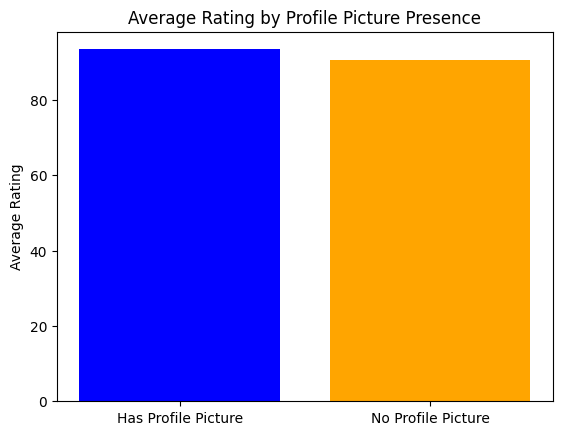

In [11]:
stats_with_pic = filtered_data.filter(F.col("host_has_profile_pic") == True).agg(
    F.avg("review_scores_rating").alias("mean_with_pic"),
    F.variance("review_scores_rating").alias("var_with_pic"),
    F.count("review_scores_rating").alias("n_with_pic")
).collect()[0]

stats_without_pic = filtered_data.filter(F.col("host_has_profile_pic") == False).agg(
    F.avg("review_scores_rating").alias("mean_without_pic"),
    F.variance("review_scores_rating").alias("var_without_pic"),
    F.count("review_scores_rating").alias("n_without_pic")
).collect()[0]

# Extract statistics
mean_with_pic = stats_with_pic["mean_with_pic"]
var_with_pic = stats_with_pic["var_with_pic"]
n_with_pic = stats_with_pic["n_with_pic"]

mean_without_pic = stats_without_pic["mean_without_pic"]
var_without_pic = stats_without_pic["var_without_pic"]
n_without_pic = stats_without_pic["n_without_pic"]

# Compute t-statistic
t_statistic = (mean_with_pic - mean_without_pic) / (
    ((var_with_pic / n_with_pic) + (var_without_pic / n_without_pic)) ** 0.5
)

# Print the result
print(f"T-Statistic: {t_statistic}")

var_with_pic = stats_with_pic["var_with_pic"]
n_with_pic = stats_with_pic["n_with_pic"]

var_without_pic = stats_without_pic["var_without_pic"]
n_without_pic = stats_without_pic["n_without_pic"]

numerator = ((var_with_pic / n_with_pic) + (var_without_pic / n_without_pic)) ** 2
denominator = ((var_with_pic / n_with_pic) ** 2) / (n_with_pic - 1) + ((var_without_pic / n_without_pic) ** 2) / (n_without_pic - 1)
df = numerator / denominator

p_value = 2 * (1 - t.cdf(abs(t_statistic), df))

print(f"Degrees of Freedom: {df}")
print(f"P-Value: {p_value}")

# Example data for visualization
group_data = {
    "Has Profile Picture": 93.411685802341,
    "No Profile Picture": 89.82424242424243
}

# Plot
plt.bar(group_data.keys(), [mean_with_pic, mean_without_pic], color=["blue", "orange"])
plt.ylabel("Average Rating")
plt.title("Average Rating by Profile Picture Presence")
plt.show()

## ii. How many hosts have joined the airbnb platform over time?

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Number of Hosts that Joined Each Year')

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Number of Hosts')

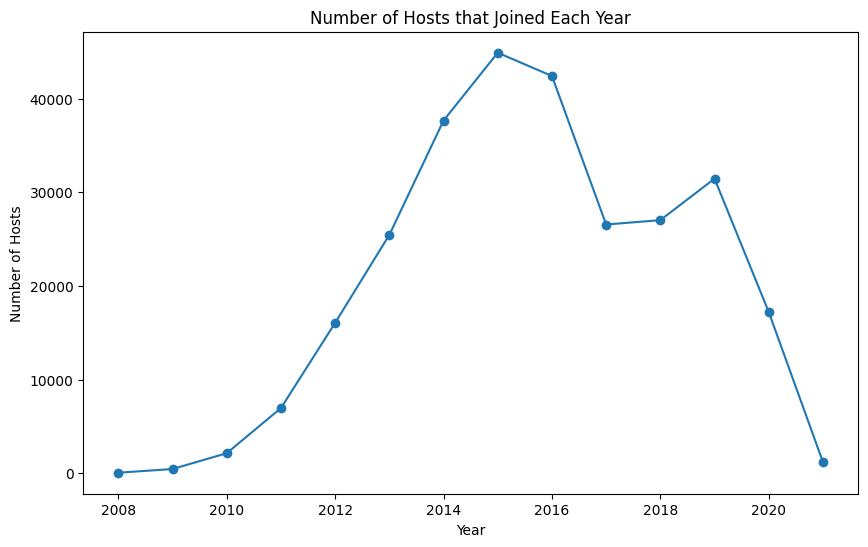

In [12]:
# Extract the year from the host_since column and count the number of hosts for each year
hosts_by_year = listings.withColumn("year", year(col("host_since"))) \
    .groupBy("year") \
    .count() \
    .orderBy("year")

# Convert the result to a Pandas DataFrame
hosts_by_year_pdf = hosts_by_year.toPandas()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(hosts_by_year_pdf['year'], hosts_by_year_pdf['count'], marker='o')
plt.title('Number of Hosts that Joined Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Hosts')
plt.grid(False)
plt.show()


## iii. How are the data points correlated?

<Figure size 1400x1200 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Heatmap of Correlation Between Features')

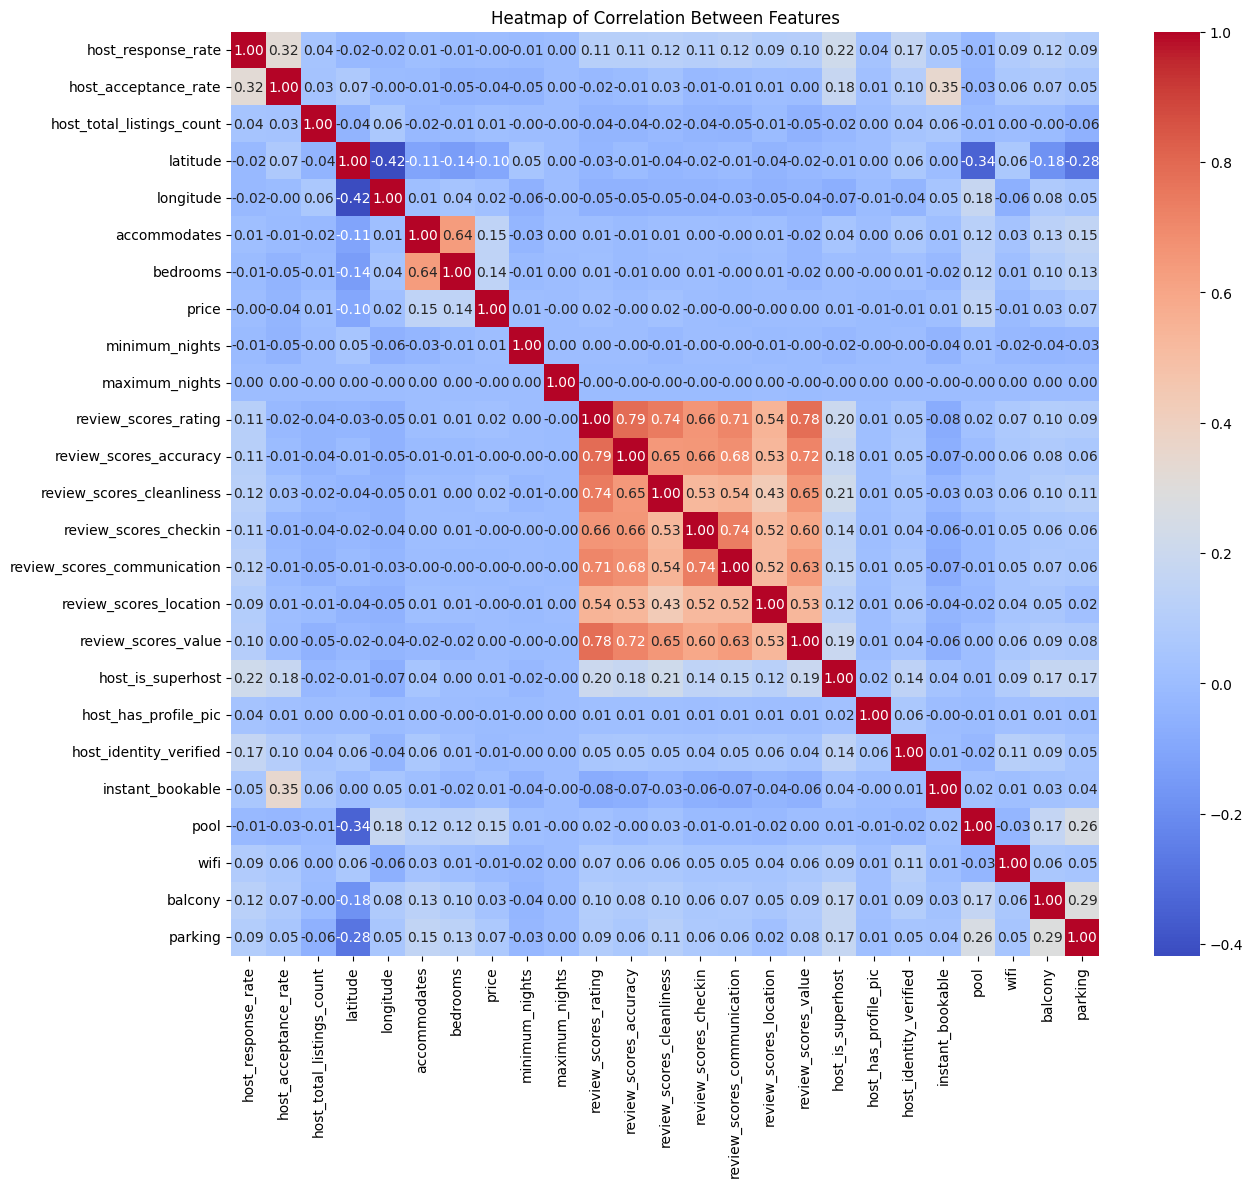

In [13]:
# Select relevant numerical and boolean columns for correlation analysis
selected_columns = [
    "host_response_rate", "host_acceptance_rate", "host_total_listings_count",
    "latitude", "longitude", "accommodates", "bedrooms", "price", 
    "minimum_nights", "maximum_nights", "review_scores_rating", 
    "review_scores_accuracy", "review_scores_cleanliness", 
    "review_scores_checkin", "review_scores_communication", 
    "review_scores_location", "review_scores_value", "host_is_superhost",
    "host_has_profile_pic", "host_identity_verified", "instant_bookable", 
    "pool", "wifi", "balcony", "parking"
]

# Convert the Spark DataFrame to a Pandas DataFrame
listings_pd = listings.select(selected_columns).toPandas()

# Calculate the correlation matrix
correlation_matrix = listings_pd.corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Heatmap of Correlation Between Features')
plt.show()


## iv. Are we getting feedback from Airbnb guests?

In [14]:
reviews = spark.sql("SELECT * FROM airbnb.reviews")
reviews.limit(3).toPandas()

,listing_id,review_id,date,reviewer_id
0,11798,330265172,2018-09-30,11863072
1,15383,330103585,2018-09-30,39147453
2,16455,329985788,2018-09-30,1125378


In [15]:
reviews.printSchema()

root
 |-- listing_id: integer (nullable = true)
 |-- review_id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- reviewer_id: integer (nullable = true)



In [16]:
listings_reviews = reviews.join(listings, on="listing_id", how="left")
listings_reviews.limit(3).toPandas()

,listing_id,review_id,date,reviewer_id,name,host_id,host_since,host_location,host_response_time,host_response_rate,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,pool,wifi,balcony,parking
0,16455,329985788,2018-09-30,1125378,"Spacious, Light-Filled Apartment",64054,2009-12-18,"Paris, Ile-de-France, France",None,NaN,...,8,10,10,9,9,False,False,True,False,True
1,11798,330265172,2018-09-30,11863072,Loft very charming in Paris,44444,2009-10-08,"Paris, Ile-de-France, France",None,NaN,...,10,10,10,10,10,False,False,True,False,True
2,15383,330103585,2018-09-30,39147453,Beautiful apt in Montmartre w/ great terrace,60248,2009-12-05,"Paris, Ile-de-France, France",None,NaN,...,10,10,10,10,10,False,False,True,False,True


<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Reviews Count by Year and Month')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Number of Reviews')

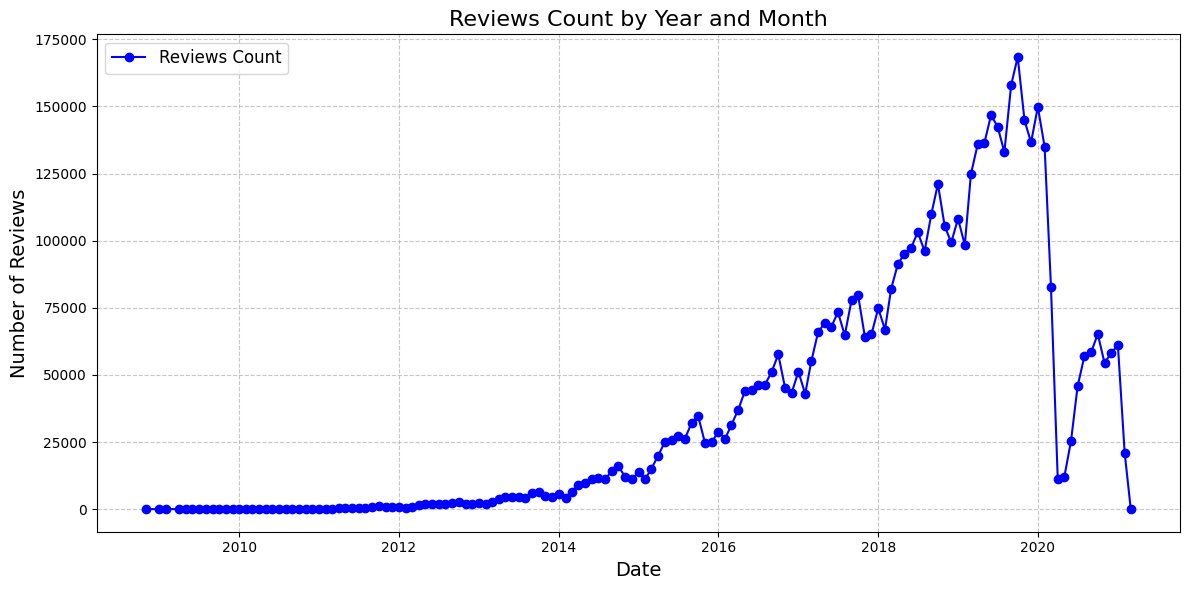

In [17]:
# Extract year and month from the date column
reviews_by_year_month = listings_reviews \
    .withColumn("year", year(col("date"))) \
    .withColumn("month", month(col("date"))) \
    .groupBy("year", "month") \
    .count() \
    .orderBy("year", "month")

# Convert the Spark DataFrame to Pandas
reviews_by_year_month_pd = reviews_by_year_month.toPandas()

# Create a datetime column from year and month
reviews_by_year_month_pd["date"] = pd.to_datetime(
    reviews_by_year_month_pd[["year", "month"]].assign(day=1)
)

# Sort by the date column to ensure proper plotting
reviews_by_year_month_pd = reviews_by_year_month_pd.sort_values("date")

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(
    reviews_by_year_month_pd["date"],
    reviews_by_year_month_pd["count"],
    marker="o",
    linestyle="-",
    color="b",
    label="Reviews Count",
)
plt.title("Reviews Count by Year and Month", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Number of Reviews", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


## v. Distribution of number of listings and average price per city

<Figure size 1400x800 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Number of Listings per city')

Text(0.5, 0, 'Number of Listings')

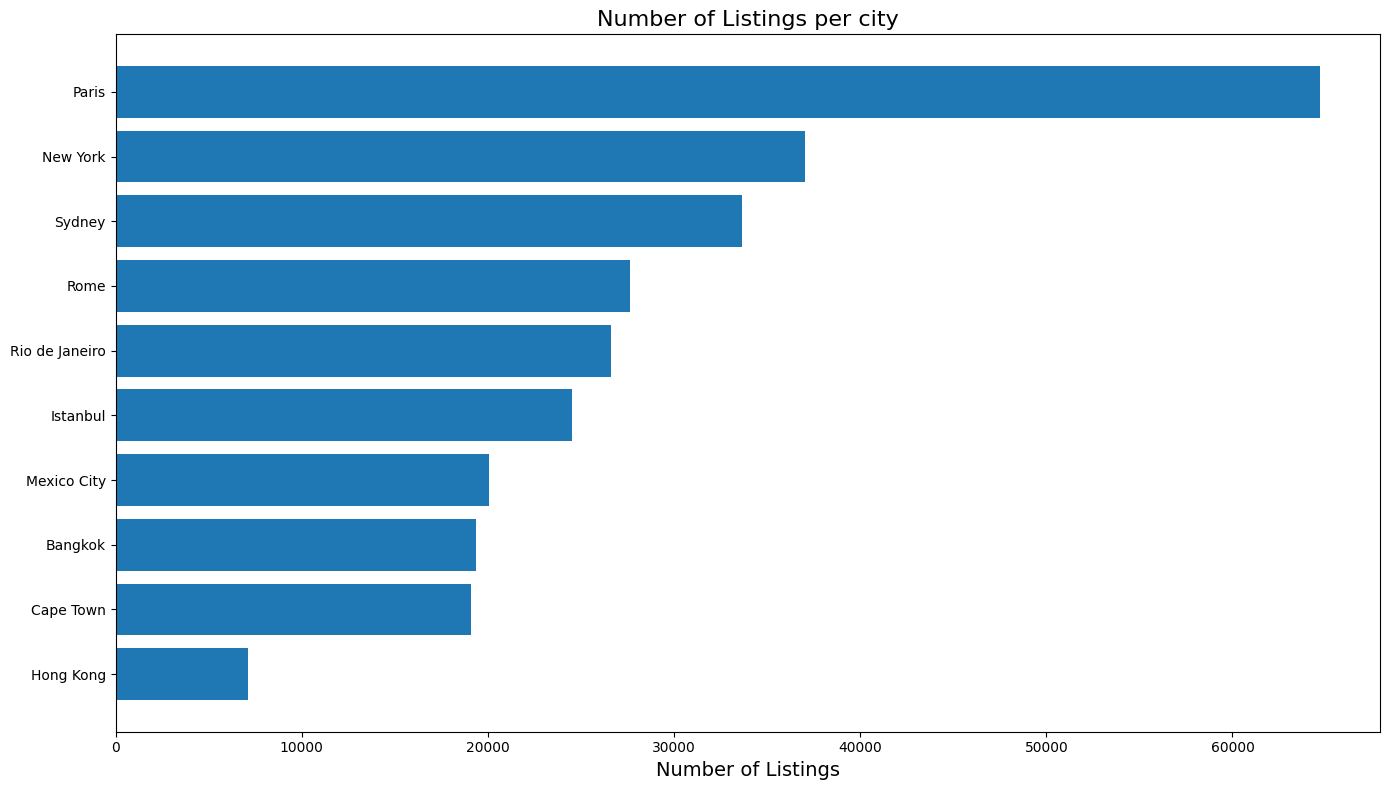

In [18]:
# Filter out rows with null city
listings_with_city = listings.filter(col("city").isNotNull())

# Group by city and count listings
listings_per_city = listings_with_city.groupBy("city").count().orderBy(col("count").desc())

listings_per_city_pd = listings_per_city.toPandas()

# Plot the distribution of listings per city

plt.figure(figsize=(14, 8))
plt.barh(
    listings_per_city_pd["city"],
    listings_per_city_pd["count"]
)

plt.title("Number of Listings per city", fontsize=16)
plt.xlabel("Number of Listings", fontsize=14)

# Invert y-axis for a better appearance
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()


<Figure size 1400x800 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 0, 'Average Price')

Text(0, 0.5, 'City')

Text(0.5, 1.0, 'Average Price Per City')

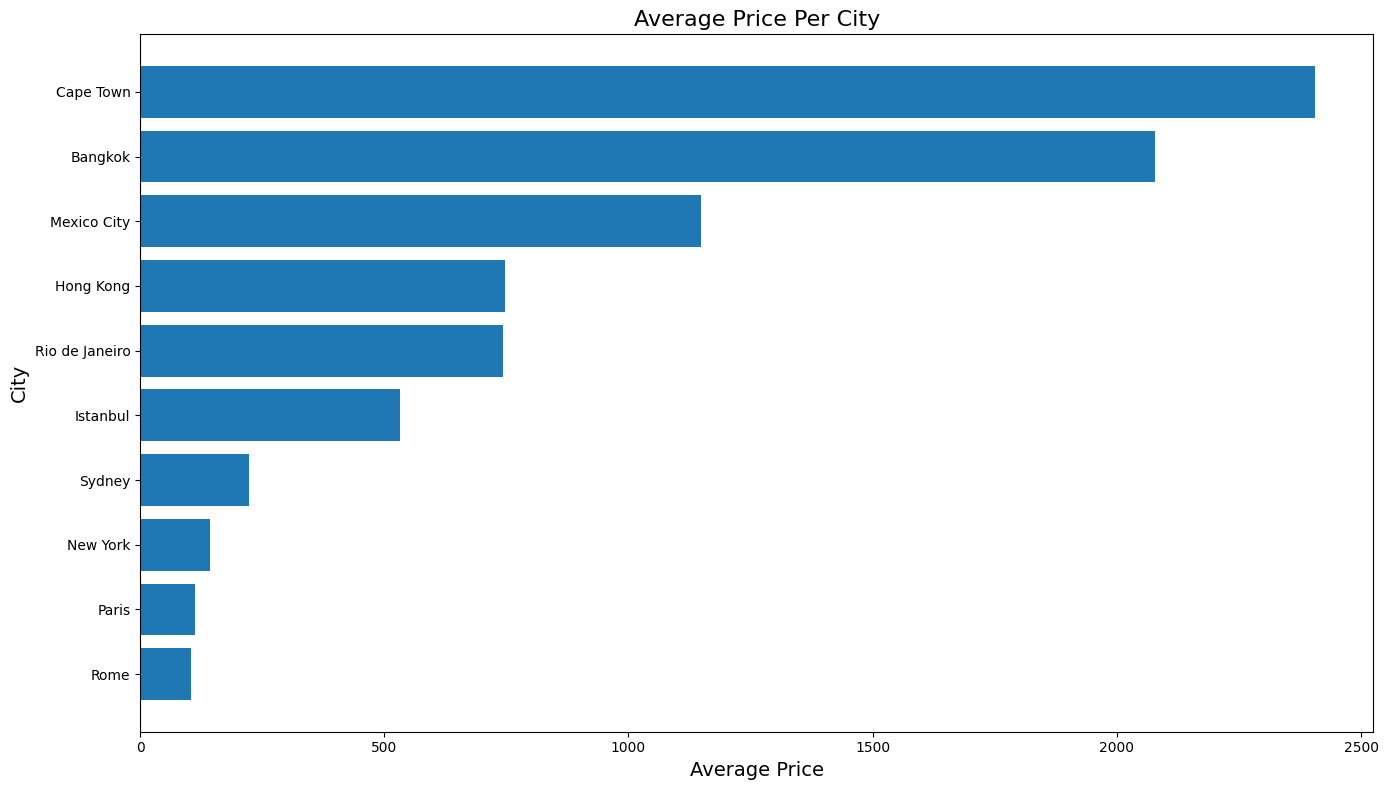

In [19]:
# Group by city and calculate average price
avg_price_per_city = listings.groupBy("city").agg(F.avg("price").alias("average_price"))

# Convert to Pandas DataFrame for plotting
avg_price_per_city_pd = avg_price_per_city.orderBy(F.col("average_price").desc()).toPandas()

# Plot the bar chart
plt.figure(figsize=(14, 8))
plt.barh(avg_price_per_city_pd["city"], avg_price_per_city_pd["average_price"])
plt.xlabel("Average Price", fontsize=14)
plt.ylabel("City", fontsize=14)
plt.title("Average Price Per City", fontsize=16)
plt.gca().invert_yaxis()  # Reverse the order of cities for better appearance
plt.tight_layout()
plt.show()


## vii. How does response time affect reviews


   host_response_time  med_review_scores_rating
0      within an hour                      96.0
1  within a few hours                      97.0
2        within a day                      96.0
3  a few days or more                      95.0
4                None                      96.0


<Figure size 1000x600 with 0 Axes>

<BarContainer object of 4 artists>

Text(0.5, 0, 'Host Response Time')

Text(0, 0.5, 'Median Review Scores Rating')

Text(0.5, 1.0, 'Host Response Time vs Median Review Scores Rating')

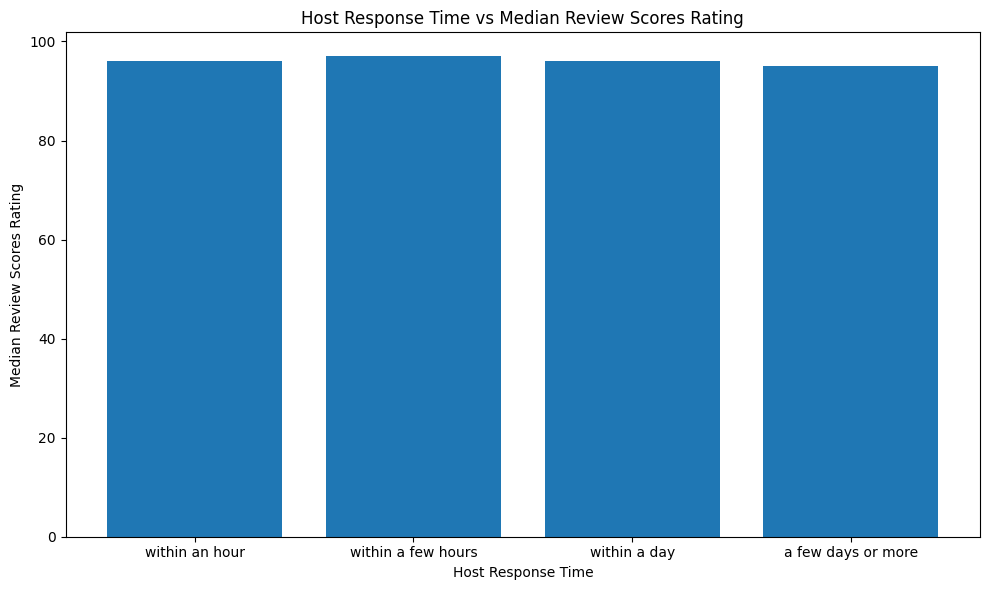

In [20]:
# Group by host_response_time and calculate the average review_scores_rating, then convert to Pandas DataFrame
result_pandas_df = listings.groupBy("host_response_time").agg(F.median("review_scores_rating").alias("med_review_scores_rating")).orderBy(listings.host_response_time.desc()).toPandas()

print(result_pandas_df)

cleaned_results = result_pandas_df.dropna(subset=["host_response_time", "med_review_scores_rating"])

x = cleaned_results["host_response_time"].tolist()
y = cleaned_results["med_review_scores_rating"].tolist()

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(x, y)
plt.xlabel("Host Response Time")
plt.ylabel("Median Review Scores Rating")
plt.title("Host Response Time vs Median Review Scores Rating")
plt.tight_layout()
plt.show()



## vi. A closer look at New York

In [21]:
# Filter listings for New York
new_york_listings = listings.filter(F.col("city") == "New York")

# Group by district and count listings
listings_per_district = new_york_listings.groupBy("district").count().orderBy(F.col("count").desc())

# Convert to Pandas DataFrame for visualization
listings_per_district_pd = listings_per_district.toPandas()

# Show the result
print(listings_per_district_pd)


        district  count
0      Manhattan  16553
1       Brooklyn  14474
2         Queens   4704
3          Bronx    992
4  Staten Island    289


### Show location of listings in Staten Island, New York

In [22]:
# Filter listings for Staten Island in New York
staten_island_listings = listings.filter(
    (F.col("city") == "New York") & (F.col("district") == "Staten Island")
)

# Collect the relevant data (latitude and longitude)
listings_data = staten_island_listings.select("latitude", "longitude").collect()

# Create a map centered around Staten Island (latitude and longitude of New York)
map_center = [40.5795, -74.1502]  # Approximate coordinates for Staten Island
listing_map = folium.Map(location=map_center, zoom_start=12)

# Add markers for each listing
for listing in listings_data:
    folium.Marker(
        location=[listing["latitude"], listing["longitude"]],
        popup="Listing",
        icon=folium.Icon(color='blue')
    ).add_to(listing_map)

# Save map to an HTML file
listing_map.save("staten_island_listings_map.html")


In [24]:
# Display the map directly in the Jupyter notebook
display(IFrame("staten_island_listings_map.html", width=800, height=600))